# Train Version 1

## Import Packages

In [64]:
import os
from functools import wraps
import gc
import random
from pathlib import Path
from datetime import datetime

# scientific
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import cm
import matplotlib
import tifffile as tiff
import pandas as pd
from scipy.ndimage import zoom

# torch
import torch
from torch.utils.data import Dataset
from torch import nn
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torch.optim import (SGD,
                         Adam, )
from torchvision.transforms import (ToTensor,
                                    Compose,
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomRotation,
                                    Normalize,
                                    ToPILImage)

## Paths

In [2]:
base_dir = Path("/home/lizard/Documents/Code/Project/stoneRegression")# project root
output_dir = base_dir.joinpath("result").joinpath(datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S'))
output_dir.mkdir(parents=True, exist_ok=True)
# in_file1 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/TheCNNmodel/Res-01")
# in_file2 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/TheCNNmodel/Res-02")
# in_file3 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/TheCNNmodel/Res-03")

# DistField
in_file1 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/InputImages_DistField/Res_01_EDT")
in_file2 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/InputImages_DistField/Res_02_EDT")
in_file3 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/InputImages_DistField/Res_03_EDT")

lb_file = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/TheCNNmodel/Labels.xlsx")



## Utility

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def flush_and_gc(f):
    @wraps(f)
    def g(*args, **kwargs):
        torch.cuda.empty_cache()
        gc.collect()
        return f(*args, **kwargs)

    return g

## Parameters
### Hyperparameters

In [4]:
EPOCHS = 10
BATCH_SIZE = 2
MOMENTUM = .9
WEIGHT_DECAY = 5e-4
N_FEATURE_MAP = 32
LR = 1e-3

### Data Augmentation

In [5]:
random_h_flip_prob = .5
random_v_flip_prob = .5
random_degree_rotate_prob = 10.
n_channel = 150

### Runtime

In [6]:
train_size_per = .9
dev_size_per = .1
seed = 2021
n_worker = 4
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
fix_all_seeds(seed=seed)

## Dataloader

In [80]:
class Stone(Dataset):
    def __init__(self, images_dir: Path, label_xlx: Path, transformers):
        self._transformers = transformers
        self._ds_root = images_dir
        self._label_root = label_xlx
        self._lb = np.squeeze(pd.read_excel(str(self._label_root)).to_numpy(), axis=-1)
        f_list = list(self._ds_root.glob("*.tif"))
        f_list.sort(key=lambda p: int(p.stem.split("-")[0]))
        self._f_list = f_list

        assert len(self._f_list) == len(self._lb)

    def __len__(self):
        return len(self._f_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        n_d_im = tiff.imread(str(self._f_list[idx]))
        n_d_im = zoom(n_d_im, (0.5, 0.5, 0.5))
        lb = torch.as_tensor(self._lb[idx])
        n_d_im = (n_d_im - n_d_im.min())/(n_d_im.max() - n_d_im.min())
        if self._transformers is not None:
            n_d_im = torch.unsqueeze(self._transformers(n_d_im.astype(np.float32)), 0)
            
        return n_d_im, lb

## Models

In [81]:
class Model3DV1(nn.Module):
    def __init__(self, n_channels, n_feature):
        super(Model3DV1, self).__init__()

        self._model = nn.Sequential(
            nn.Conv3d(in_channels=n_channels, out_channels=n_feature, kernel_size=3),
            nn.MaxPool3d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=n_feature, out_channels=n_feature * 2, kernel_size=3),
            nn.MaxPool3d(kernel_size=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels=n_feature * 2, out_channels=n_feature * 4, kernel_size=3),
            nn.MaxPool3d(kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=170368, out_features=1),
            # nn.Sigmoid()
        )

    def forward(self, x: Tensor) -> Tensor:
        return self._model(x)

## Transfomers

In [83]:
def get_transforms(p_hor=.5, p_ver=.5, r_degree=10, mean=.5, std=.5, n_channel=300):
    return Compose([
        ToTensor(),
        Normalize(mean=[mean] * n_channel, std=[std] * n_channel),
        RandomHorizontalFlip(p=p_hor),
        RandomVerticalFlip(p=p_ver),
        RandomRotation(degrees=r_degree), 
    ])

## Show some data

Permeability:  33.81



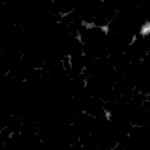
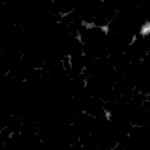
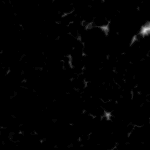
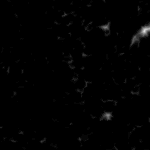
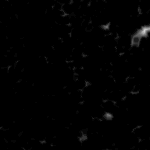
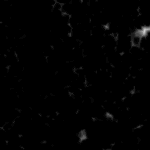
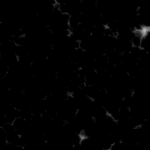
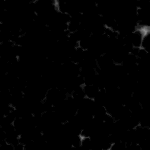
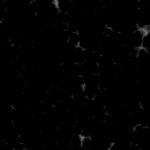
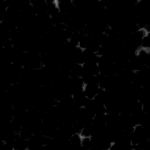
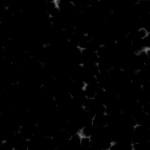
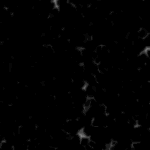
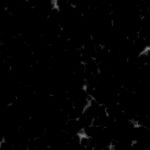
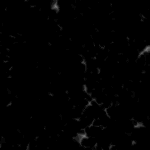
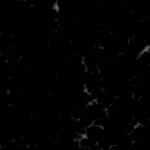
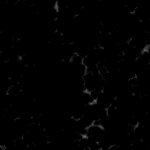
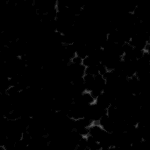
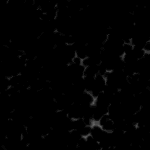
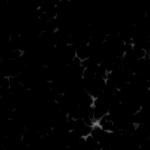
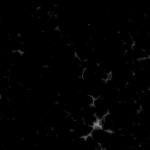
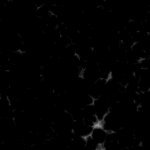
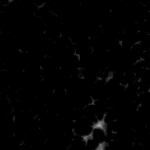
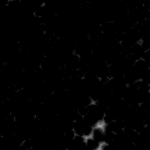
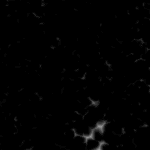
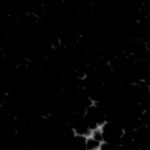
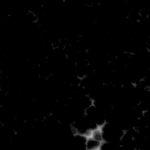
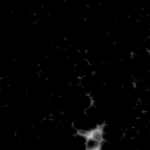
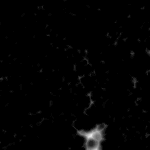
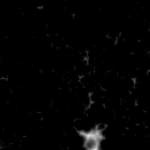
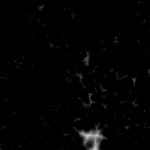
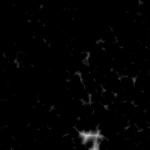
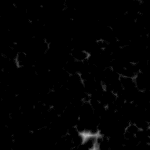
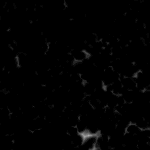
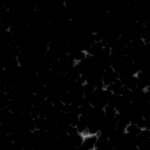
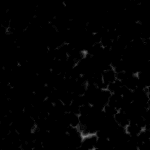
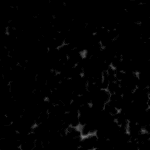
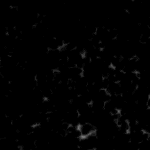
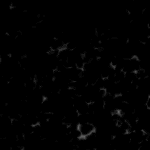
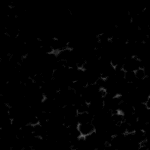
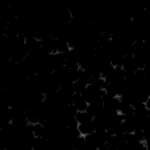
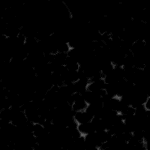
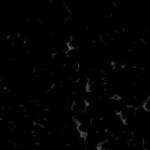
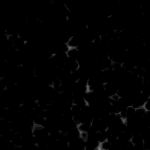
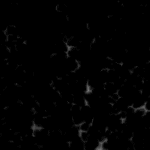
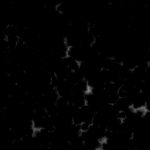
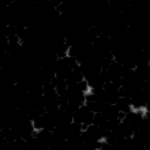
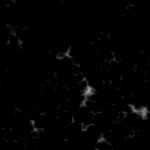
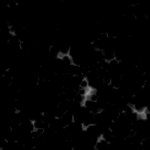
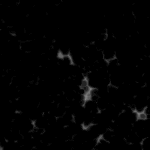
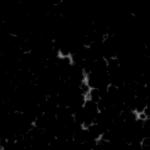
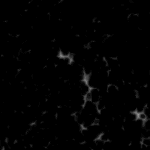
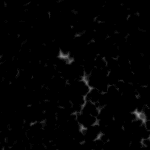
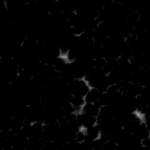
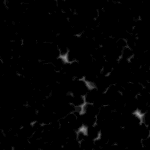
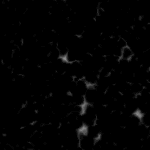
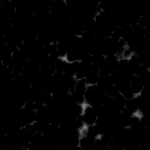
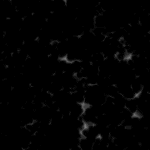
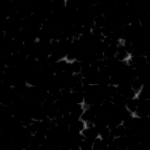
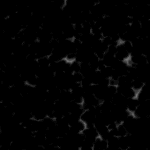
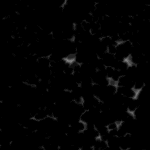
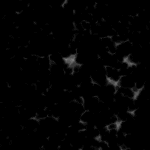
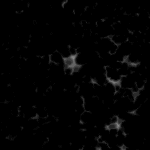
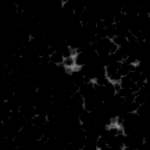
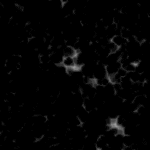
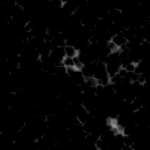
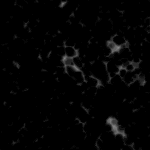
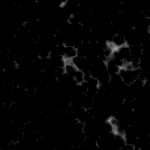
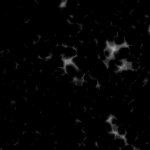
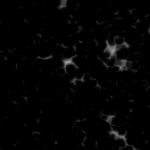
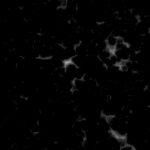
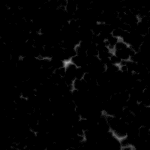
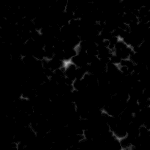
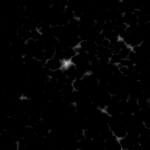
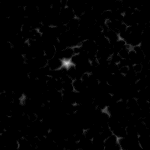
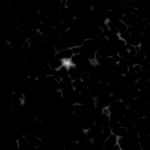
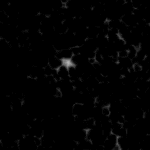
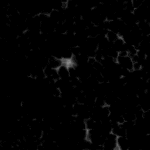
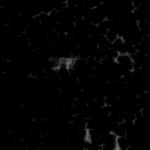
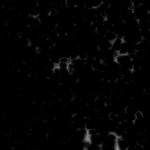
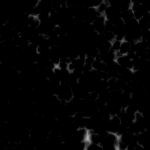
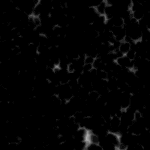
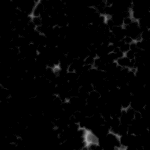
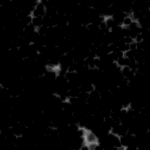
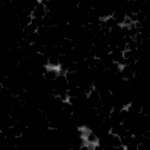
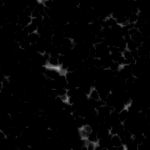
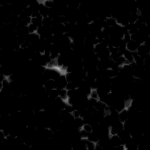
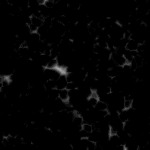
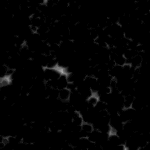
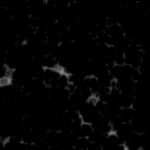
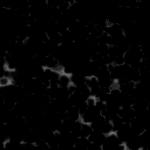
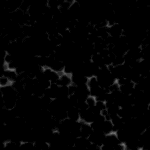
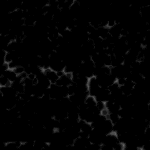
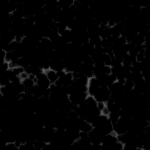
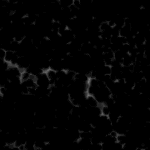
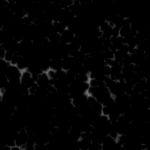
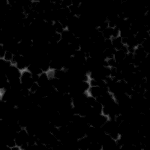
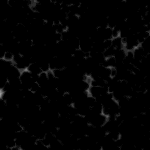
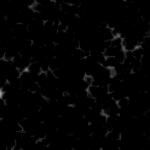
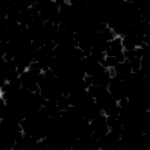
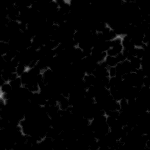
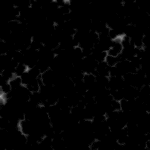
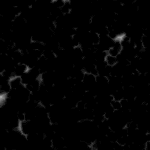
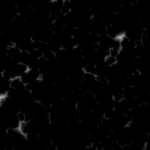
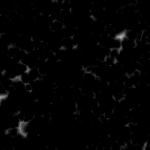
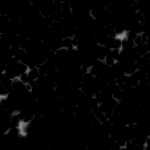
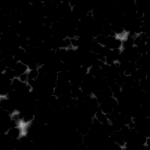
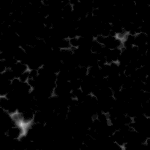
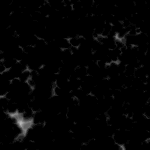
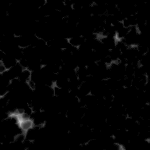
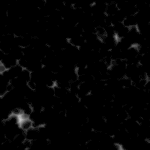
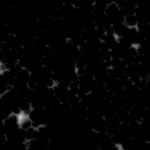
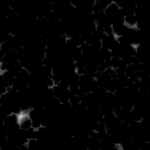
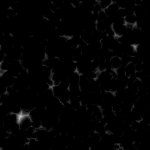
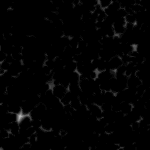
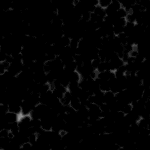
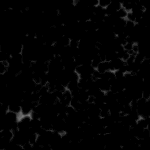
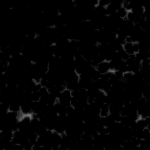
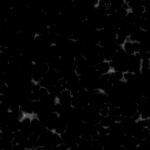
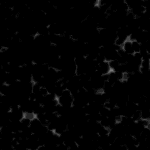
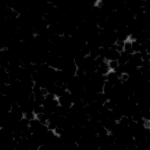
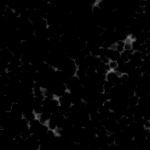
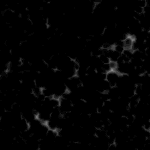
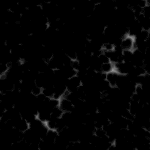
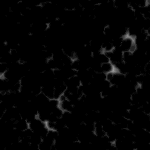
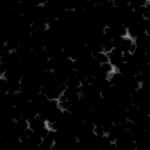
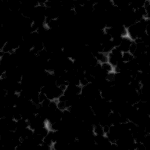
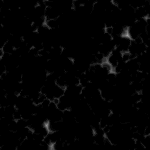
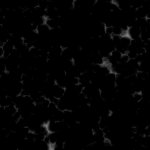
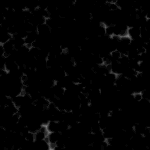
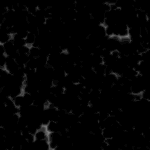
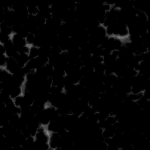
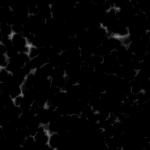
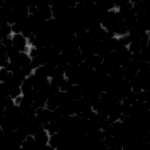
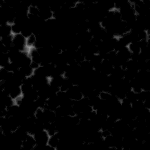
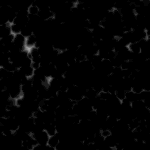
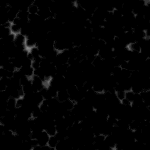
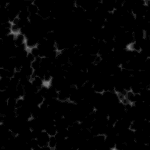
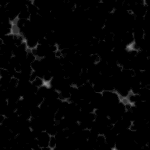
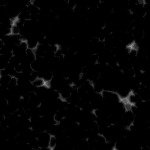
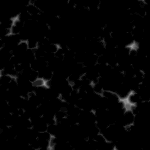
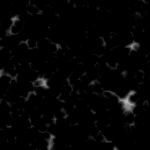
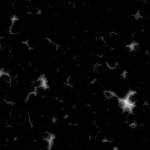
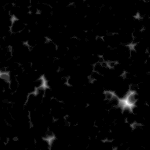
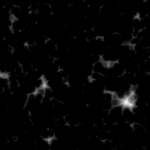
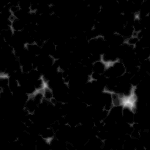
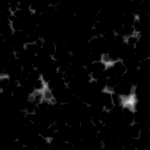
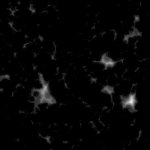
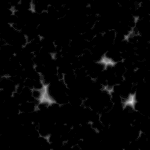
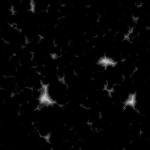
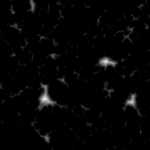
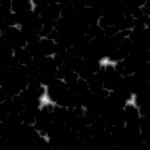

In [84]:
ts_ds = Stone(images_dir=in_file1,
                label_xlx=lb_file,
                transformers=None)
ts_data,ts_lb = ts_ds[np.random.randint(0,len(ts_ds))]
print("Permeability: ",ts_lb.item())
fig = px.imshow(ts_data, animation_frame=0, binary_string=True, labels=dict(animation_frame="scan"), height=600)
fig.show()

## Trainer

In [86]:
class BaseTrain:
    def __init__(self, *args, **kwargs):
        super(BaseTrain).__init__(*args, **kwargs)

    @flush_and_gc
    def train_step(self, **kwargs):
        raise NotImplementedError

    @flush_and_gc
    def validation_step(self, **kwargs):
        raise NotImplementedError

    def train(self, **kwargs):
        raise NotImplementedError


class TrainerV1(BaseTrain):
    def __init__(self, *args, **kwargs):
        super(TrainerV1, self).__init__()
        self._model = kwargs["model"]
        self._device = kwargs["device"]
        self._criterion = kwargs["criterion"]()
        self._opt = kwargs["opt"]
        self._scheduler = kwargs["scheduler"]

        self._model.to(self._device)
        self._opt = self._opt(self._model.parameters(),
                              lr=kwargs["lr"],
                              momentum=kwargs["momentum"],
                              weight_decay=kwargs["weight_decay"])
        self._scheduler = self._scheduler(self._opt,
                                          step_size=3,
                                          gamma=0.1)
        
    @property
    def model(self):
        return self._model

    @flush_and_gc
    def train_step(self, **kwargs):
        data, lb = kwargs["batch"]
        data = data.to(self._device)
        lb = torch.unsqueeze(lb, dim=-1)
        lb = lb.to(self._device)
        loss = self._criterion(self._model(data), lb)
        self._opt.zero_grad()
        loss.backward()
        self._opt.step()
        return loss.item()

    @flush_and_gc
    def validation_step(self, **kwargs):
        data, lb = kwargs["batch"]
        data = data.to(self._device)
        lb = torch.unsqueeze(lb, dim=-1)
        lb = lb.to(self._device)
        return self._criterion(self._model(data), lb).item()

    def train(self, **kwargs):
        print(f"-> Training is now starting")
        train_ld = kwargs["train_ld"]
        dev_ld = kwargs["dev_ld"]

        glob_t_loss = []
        glob_d_loss = []

        epochs = kwargs["epochs"]
        glob_step = 0
        for epoch in range(epochs):
            tm_t_loss = []
            prefix = f"[{epoch + 1}|{epochs}] epoch,"

            # train step
            self._model.train()
            for batch_idx, batch in enumerate(train_ld):
                ls = self.train_step(batch=batch)
                tm_t_loss.append(ls)

                # show the result
                if glob_step + 1 % 10 == 0:
                    print(f"{prefix} [{batch_idx}] batch, Loss -> train: {tm_t_loss[-1]}")

                glob_step += 1

            glob_t_loss.append(np.array(tm_t_loss).mean())
            self._scheduler.step()

            # validation step
            tm_d_loss = []
            self._model.eval()
            with torch.no_grad():
                for batch_idx, batch in enumerate(dev_ld):
                    ls = self.validation_step(batch=batch)
                    tm_d_loss.append(ls)

            glob_d_loss.append(np.array(tm_d_loss).mean())

            print(f"{prefix}, Loss -> train: {glob_t_loss[-1]}, dev: {glob_d_loss[-1]}")
        return {"train_loss":np.array(glob_t_loss),"dev_loss":np.array(glob_d_loss)}

    def save(self, **kwargs):
        torch.save(self._model.state_dict(), str(kwargs["save_path"].joinpath("model.pth")))

## Train model

In [87]:
model = Model3DV1(n_channels=1, n_feature=N_FEATURE_MAP)
criterion = nn.L1Loss
opt = SGD
scheduler = StepLR

dataset1 = Stone(images_dir=in_file1,
                label_xlx=lb_file,
                transformers=get_transforms(p_hor=random_h_flip_prob,
                                            p_ver=random_v_flip_prob,
                                            r_degree=random_degree_rotate_prob,
                                            n_channel=n_channel
                                            ))
dataset2 = Stone(images_dir=in_file2,
                label_xlx=lb_file,
                transformers=get_transforms(p_hor=random_h_flip_prob,
                                            p_ver=random_v_flip_prob,
                                            r_degree=random_degree_rotate_prob,
                                            n_channel=n_channel
                                            ))

dataset3 = Stone(images_dir=in_file3,
                label_xlx=lb_file,
                transformers=get_transforms(p_hor=random_h_flip_prob,
                                            p_ver=random_v_flip_prob,
                                            r_degree=random_degree_rotate_prob,
                                            n_channel=n_channel
                                            ))
assert len(dataset1)==len(dataset2)
assert len(dataset2)==len(dataset3)
train_size = int(len(dataset1) * train_size_per)
dev_size = len(dataset1) - train_size
train_set1, dev_set1 = random_split(dataset1, [train_size, dev_size])
train_set2, dev_set2 = random_split(dataset2, [train_size, dev_size])
train_set3, dev_set3 = random_split(dataset3, [train_size, dev_size])

dl1_train = DataLoader(train_set1,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=n_worker)

dl1_dev = DataLoader(dev_set1,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    num_workers=n_worker)

dl2_train = DataLoader(train_set2,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=n_worker)

dl2_dev = DataLoader(dev_set2,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    num_workers=n_worker)

dl3_train = DataLoader(train_set3,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=n_worker)

dl3_dev = DataLoader(dev_set3,
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    num_workers=n_worker)

loader_1 = (dl1_train,dl1_dev)
loader_2 = (dl2_train,dl2_dev)
loader_3 = (dl3_train,dl3_dev)

trainer1 = TrainerV1(model=model,
                    criterion=criterion,
                    opt=opt,
                    scheduler=scheduler,
                    device=device,
                    weight_decay=WEIGHT_DECAY,
                    lr=LR,
                    momentum=MOMENTUM)



### Train on Res - 1

In [89]:
res1 = trainer1.train(train_ld=loader_1[0], dev_ld=loader_1[1], epochs=EPOCHS)

-> Training is now starting
[1|10] epoch,, Loss -> train: 28.770299116770428, dev: 16.429360071818035
[2|10] epoch,, Loss -> train: 33.427334202660454, dev: 18.431464513142902
[3|10] epoch,, Loss -> train: 26.063208438732005, dev: 34.071545918782554
[4|10] epoch,, Loss -> train: 15.996100231453225, dev: 17.920980135599773
[5|10] epoch,, Loss -> train: 14.821536858876547, dev: 18.24614683787028
[6|10] epoch,, Loss -> train: 14.09957852628496, dev: 17.347704887390137
[7|10] epoch,, Loss -> train: 13.783836638485944, dev: 17.72745164235433
[8|10] epoch,, Loss -> train: 14.125193587055913, dev: 17.943751335144043
[9|10] epoch,, Loss -> train: 14.007327380003753, dev: 18.15341281890869
[10|10] epoch,, Loss -> train: 13.807418275762487, dev: 18.13701597849528


### Train on Res - 2

In [90]:
trainer2 = TrainerV1(model=trainer1.model,
                    criterion=criterion,
                    opt=opt,
                    scheduler=scheduler,
                    device=device,
                    weight_decay=WEIGHT_DECAY,
                    lr=LR,
                    momentum=MOMENTUM)

res2 = trainer2.train(train_ld=loader_2[0], dev_ld=loader_2[1], epochs=EPOCHS)

-> Training is now starting
[1|10] epoch,, Loss -> train: 15.35740386998212, dev: 10.62184445063273
[2|10] epoch,, Loss -> train: 27.05127648954038, dev: 22.33683745066325
[3|10] epoch,, Loss -> train: 17.676453555071795, dev: 11.676494121551514
[4|10] epoch,, Loss -> train: 14.396666085278547, dev: 16.466382026672363
[5|10] epoch,, Loss -> train: 15.25973931065312, dev: 14.636262734731039
[6|10] epoch,, Loss -> train: 15.399739609824287, dev: 14.451632658640543
[7|10] epoch,, Loss -> train: 14.156564465275517, dev: 15.283878008524576
[8|10] epoch,, Loss -> train: 14.272470359449033, dev: 15.23039722442627
[9|10] epoch,, Loss -> train: 14.412770589192709, dev: 15.059816042582193
[10|10] epoch,, Loss -> train: 14.415913122671622, dev: 15.069191932678223


### Train on Res - 3

In [91]:
trainer3 = TrainerV1(model=trainer2.model,
                    criterion=criterion,
                    opt=opt,
                    scheduler=scheduler,
                    device=device,
                    weight_decay=WEIGHT_DECAY,
                    lr=LR,
                    momentum=MOMENTUM)
res3 = trainer3.train(train_ld=loader_3[0], dev_ld=loader_3[1], epochs=EPOCHS)
trainer3.save(save_path=output_dir)

-> Training is now starting
[1|10] epoch,, Loss -> train: 15.542237091947484, dev: 19.13141854604085
[2|10] epoch,, Loss -> train: 18.89039412251225, dev: 13.815718015034994
[3|10] epoch,, Loss -> train: 18.385730659520185, dev: 10.078468958536783
[4|10] epoch,, Loss -> train: 14.999362190564474, dev: 9.83457056681315
[5|10] epoch,, Loss -> train: 15.365722762213814, dev: 12.797004063924154
[6|10] epoch,, Loss -> train: 15.165117219642356, dev: 10.321326891581217
[7|10] epoch,, Loss -> train: 14.609426957589609, dev: 10.33737595876058
[8|10] epoch,, Loss -> train: 14.739119794633654, dev: 10.337636629740397
[9|10] epoch,, Loss -> train: 15.0269646997805, dev: 10.911615689595541
[10|10] epoch,, Loss -> train: 14.850731602421513, dev: 10.881806373596191


## Plot learning curve

In [92]:
plt.style.use('ggplot')

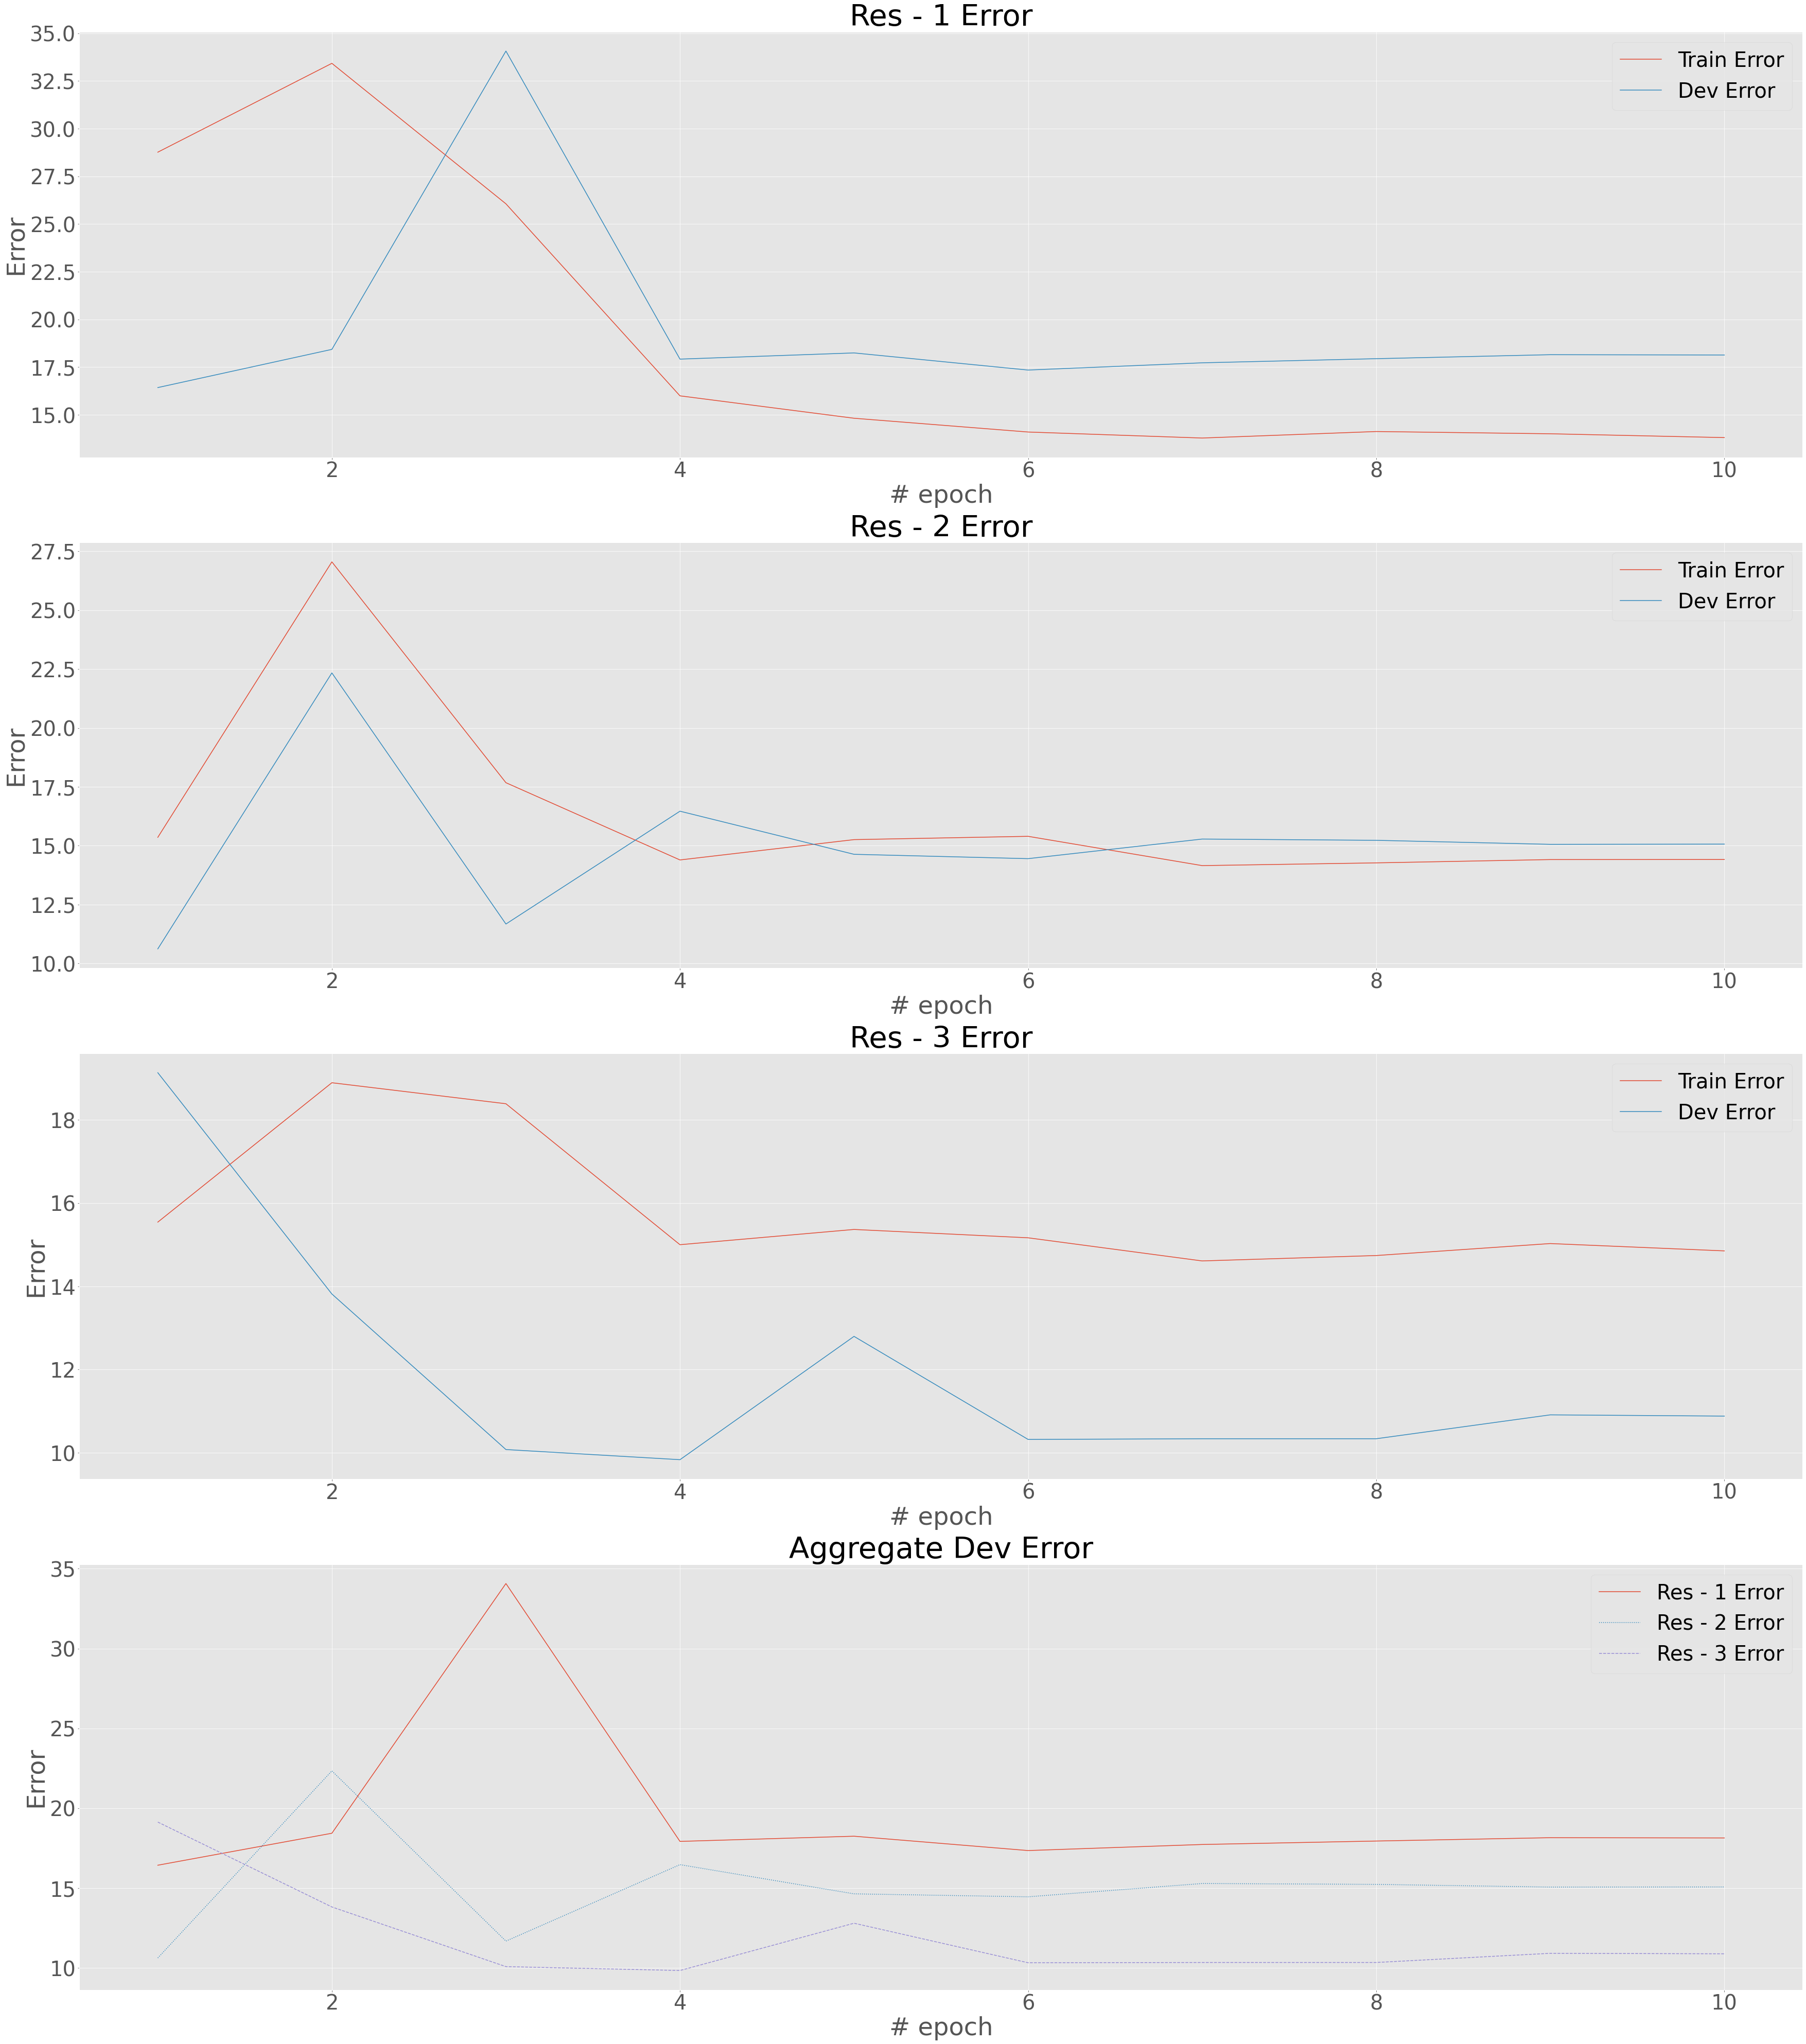

In [93]:
plt.rcParams["figure.figsize"] = (60,70)

font = {'size'   : 40}

matplotlib.rc('font', **font)

fig,axes = plt.subplots(4,1)
axes[0].set_title("Res - 1 Error")
axes[0].plot(np.arange(EPOCHS)+1,res1["train_loss"],label="Train Error")
axes[0].plot(np.arange(EPOCHS)+1,res1["dev_loss"],label="Dev Error")
axes[0].set_xlabel("# epoch")
axes[0].set_ylabel("Error")
axes[0].legend()

axes[1].set_title("Res - 2 Error")
axes[1].plot(np.arange(EPOCHS)+1,res2["train_loss"],label="Train Error")
axes[1].plot(np.arange(EPOCHS)+1,res2["dev_loss"],label="Dev Error")
axes[1].set_xlabel("# epoch")
axes[1].set_ylabel("Error")
axes[1].legend()

axes[2].set_title("Res - 3 Error")
axes[2].plot(np.arange(EPOCHS)+1,res3["train_loss"],label="Train Error")
axes[2].plot(np.arange(EPOCHS)+1,res3["dev_loss"],label="Dev Error")
axes[2].set_xlabel("# epoch")
axes[2].set_ylabel("Error")
axes[2].legend()

axes[3].set_title("Aggregate Dev Error")
axes[3].plot(np.arange(EPOCHS)+1,res1["dev_loss"],label="Res - 1 Error")
axes[3].plot(np.arange(EPOCHS)+1,res2["dev_loss"],label="Res - 2 Error",linestyle="dotted")
axes[3].plot(np.arange(EPOCHS)+1,res3["dev_loss"],label="Res - 3 Error",linestyle="dashed")
axes[3].set_xlabel("# epoch")
axes[3].set_ylabel("Error")
axes[3].legend()

plt.show()

## Show some result
> plot show prediction on unseen data

In [94]:
with torch.no_grad():
    ts_data,ts_lb = dataset3[np.random.randint(0,len(dataset3))]
    ts_data = ts_data.to(device)
    trainer3.model.eval()
    ts_pred = trainer3.model(torch.unsqueeze(ts_data,axis=0))


True Permeability: 47.95, Predicted Permeability: 41.92329025268555



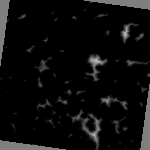
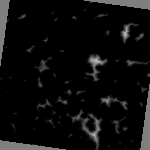
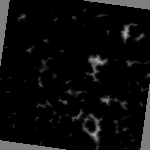
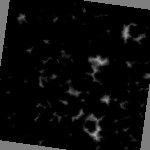
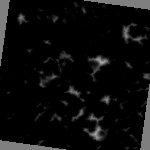
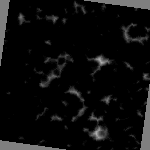
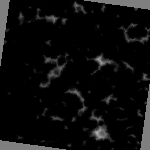
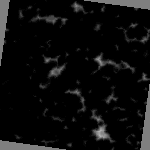
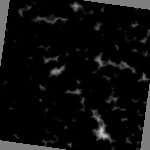
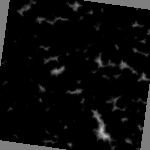
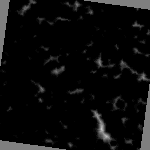
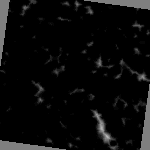
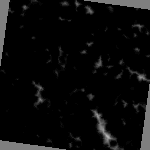
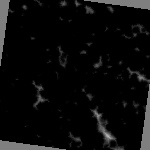
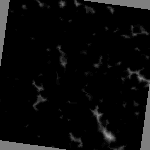
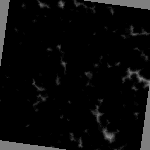
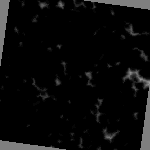
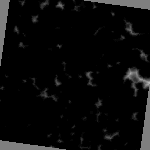
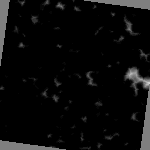
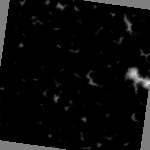
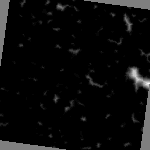
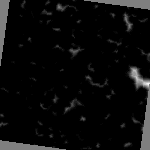
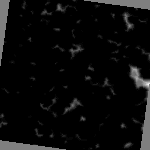
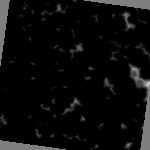
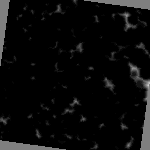
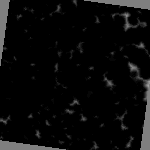
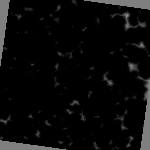
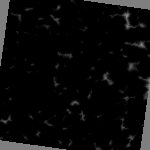
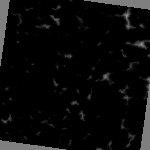
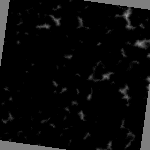
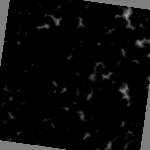
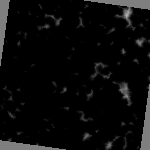
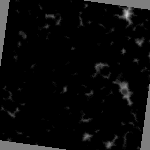
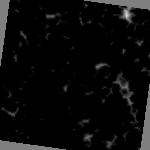
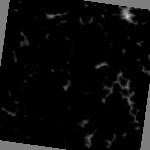
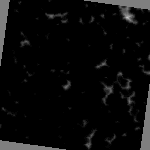
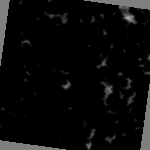
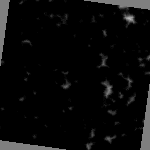
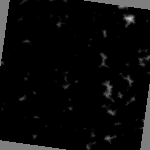
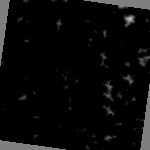
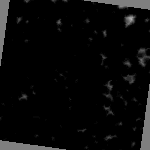
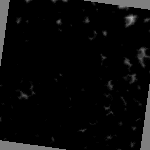
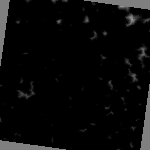
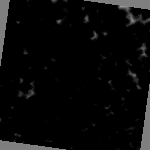
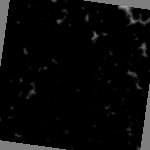
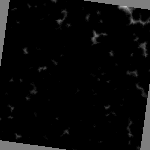
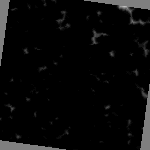
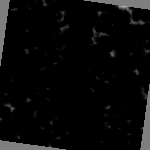
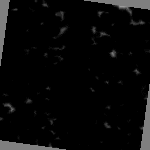
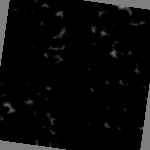
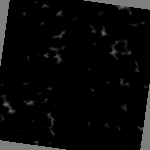
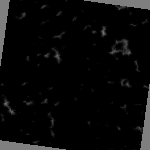
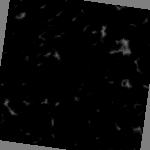
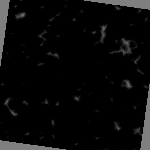
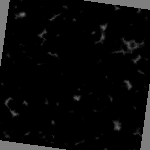
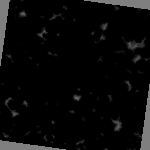
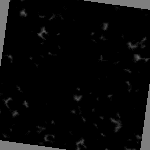
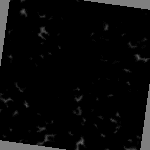
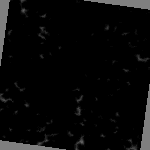
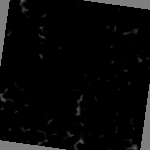
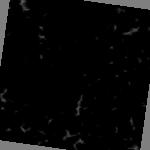
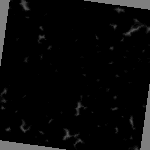
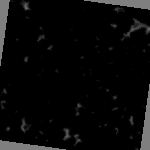
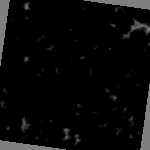
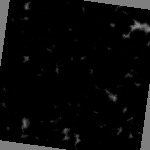
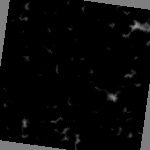
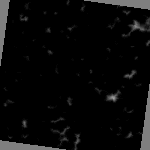
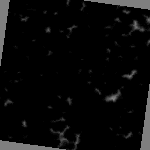
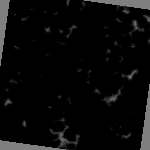
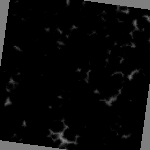
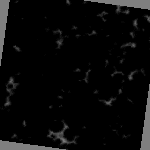
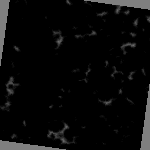
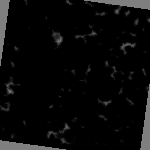
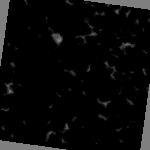
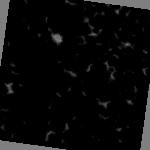
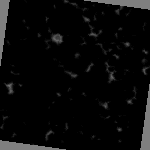
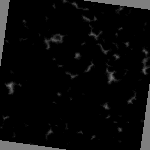
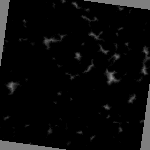
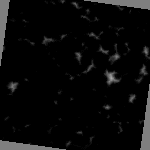
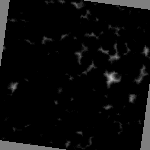
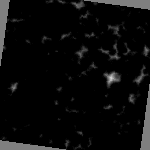
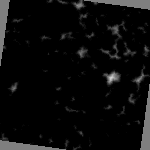
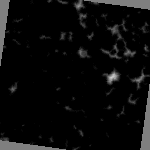
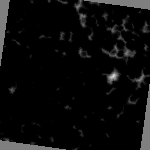
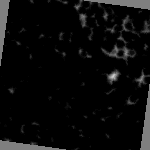
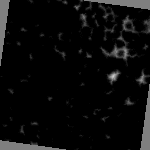
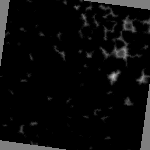
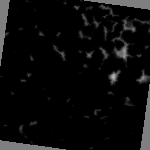
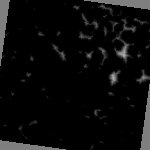
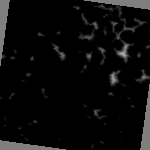
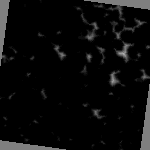
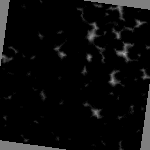
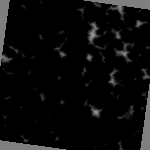
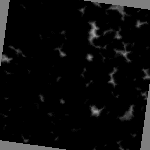
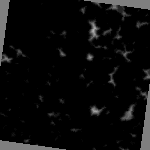
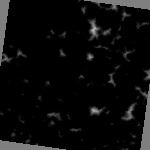
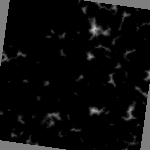
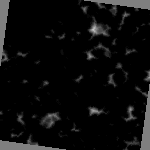
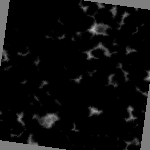
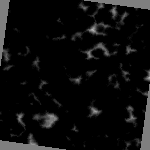
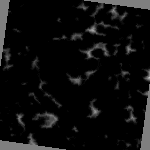
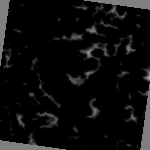
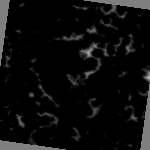
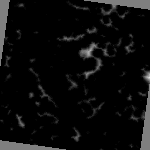
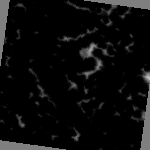
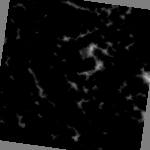
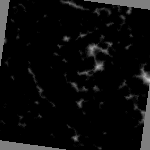
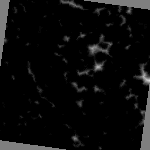
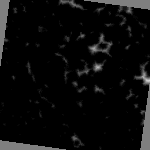
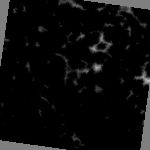
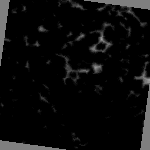
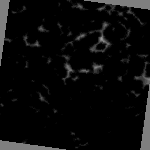
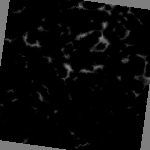
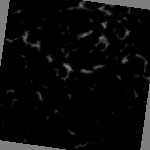
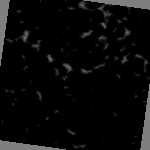
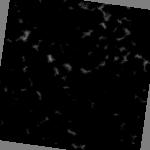
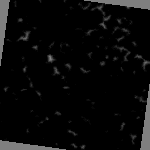
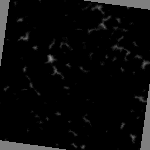
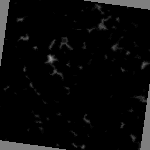
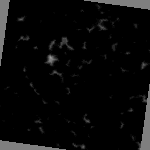
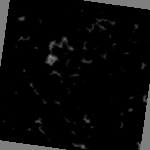
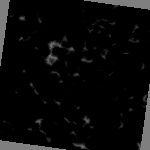
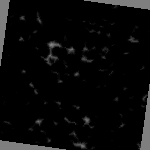
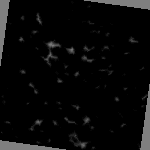
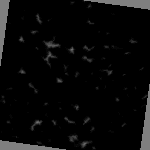
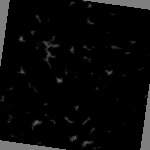
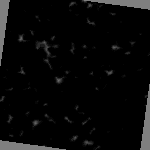
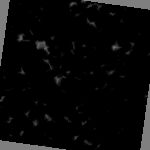
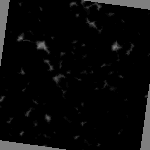
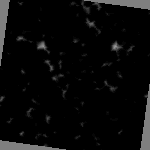
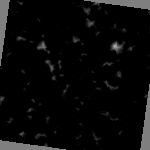
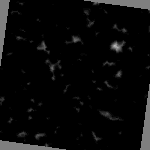
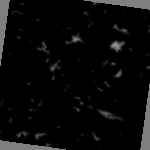
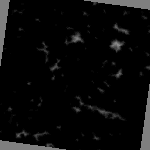
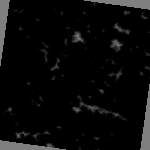
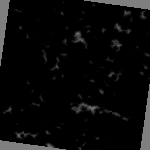
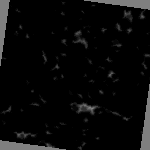
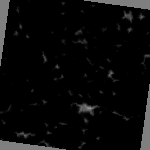
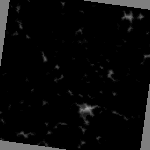
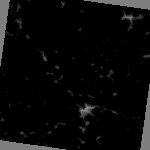
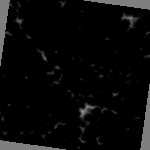
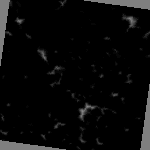
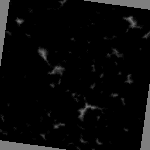
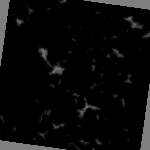
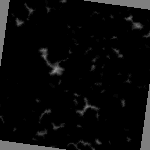
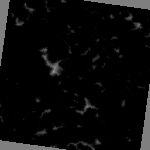
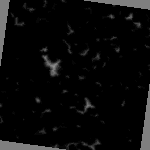
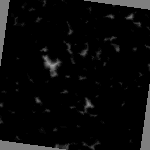
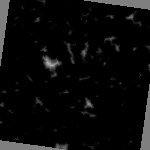
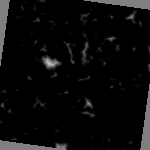
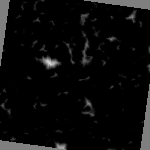

In [95]:
ts_data_list = np.squeeze(ts_data.cpu(),0).numpy()
print(f"True Permeability: {ts_lb.item()}, Predicted Permeability: {ts_pred[0][0]}")
fig = px.imshow(ts_data_list, animation_frame=0, binary_string=True, labels=dict(animation_frame="scan"), height=600)
fig.show()